## Load training and validation data

In [64]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load training and validation data
artist_train = pd.read_csv('wikiart_csv/artist_train.csv', header=None, names=['image_path', 'artist'])
genre_train = pd.read_csv('wikiart_csv/genre_train.csv', header=None, names=['image_path', 'genre'])
style_train = pd.read_csv('wikiart_csv/style_train.csv', header=None, names=['image_path', 'style'])
artist_val = pd.read_csv('wikiart_csv/artist_val.csv', header=None, names=['image_path', 'artist'])
genre_val = pd.read_csv('wikiart_csv/genre_val.csv', header=None, names=['image_path', 'genre'])
style_val = pd.read_csv('wikiart_csv/style_val.csv', header=None, names=['image_path', 'style'])

# Merge data
train_data = artist_train.merge(genre_train, on='image_path').merge(style_train, on='image_path')
val_data = artist_val.merge(genre_val, on='image_path').merge(style_val, on='image_path')

# Function to check if an image is valid
def is_image_valid(image_path):
    if not os.path.exists(image_path):
        return False
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        if image.shape[-1] != 3:  # Ensure 3 channels (RGB)
            print(f"Skipping non-RGB image: {image_path}")
            return False
        return True
    except:
        print(f"Skipping corrupted image: {image_path}")
        return False

# Sample 20% of the data
train_data = train_data.sample(frac=0.2, random_state=42)  # random_state for reproducibility
val_data = val_data.sample(frac=0.2, random_state=42)  # random_state for reproducibility

# Update image paths
train_data['image_path'] = train_data['image_path'].apply(lambda x: os.path.join('wikiart', x))
val_data['image_path'] = val_data['image_path'].apply(lambda x: os.path.join('wikiart', x))

# Filter out rows with missing or invalid files
train_data = train_data[train_data['image_path'].apply(is_image_valid)]
val_data = val_data[val_data['image_path'].apply(is_image_valid)]

# Print dataset sizes after filtering
print(f"Training dataset size after filtering: {len(train_data)}")
print(f"Validation dataset size after filtering: {len(val_data)}")


Training dataset size after filtering: 2248
Validation dataset size after filtering: 937


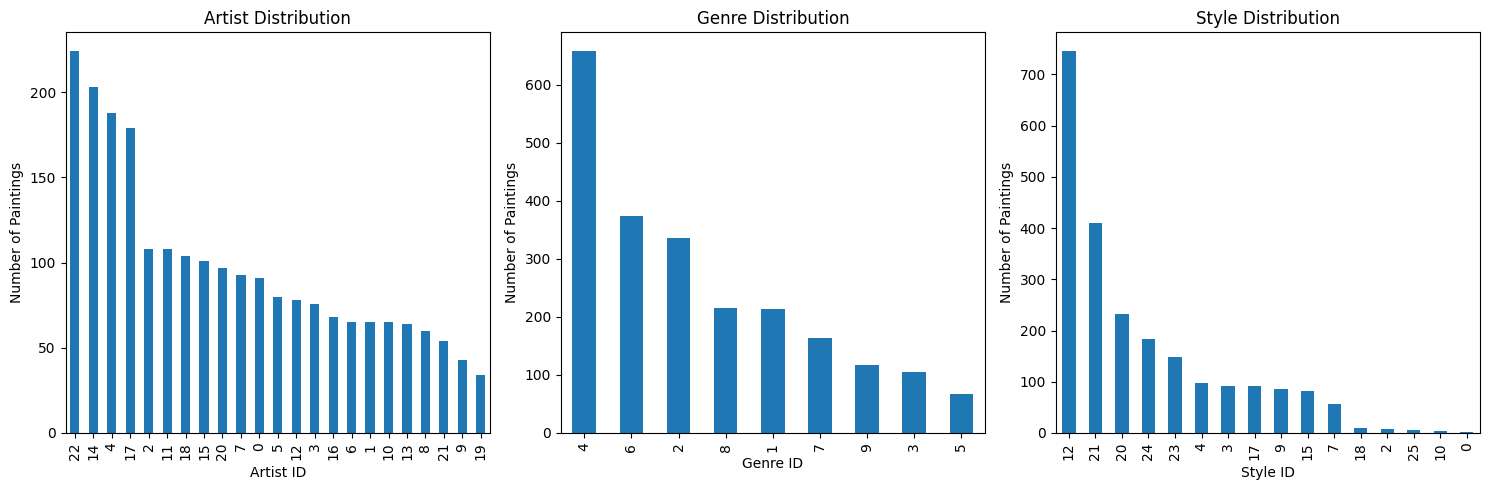

In [65]:
def plot_distribution(column, title, xlabel, position):
    plt.subplot(1, 3, position)
    train_data[column].value_counts().plot(kind='bar', title=title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Paintings')

# Create the figure
plt.figure(figsize=(15, 5))

# Plot each distribution
plot_distribution('artist', 'Artist Distribution', 'Artist ID', 1)
plot_distribution('genre', 'Genre Distribution', 'Genre ID', 2)
plot_distribution('style', 'Style Distribution', 'Style ID', 3)

# Adjust layout and display
plt.tight_layout()
plt.show()

## feature extraction to all images

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

# Apply feature extraction to all images
train_data['features'] = train_data['image_path'].apply(extract_features)
val_data['features'] = val_data['image_path'].apply(extract_features)

## Fit PCA on training data

In [67]:

# Fit PCA on training data
pca = PCA(n_components=2)
feature_matrix = np.vstack(train_data['features'].values)
feature_matrix_val = np.vstack(val_data['features'].values)
pca.fit(feature_matrix)

# Apply PCA to both datasets
train_data['pca_1'] = pca.transform(feature_matrix)[:, 0]
train_data['pca_2'] = pca.transform(feature_matrix)[:, 1]
val_data['pca_1'] = pca.transform(feature_matrix_val)[:, 0]
val_data['pca_2'] = pca.transform(feature_matrix_val)[:, 1]

import plotly.express as px

# Create an interactive scatter plot for Style
fig = px.scatter(train_data, x='pca_1', y='pca_2', color='style',
                 title='PCA of Painting Features (Colored by Style)',
                 labels={'pca_1': 'PCA Component 1', 'pca_2': 'PCA Component 2', 'style': 'Style ID'},
                 hover_data=['artist', 'genre', 'style'])  # Add hover information
fig.show()

# Repeat for Genre and Artist
fig = px.scatter(train_data, x='pca_1', y='pca_2', color='genre',
                 title='PCA of Painting Features (Colored by Genre)',
                 labels={'pca_1': 'PCA Component 1', 'pca_2': 'PCA Component 2', 'genre': 'Genre ID'},
                 hover_data=['artist', 'genre', 'style'])
fig.show()

fig = px.scatter(train_data, x='pca_1', y='pca_2', color='artist',
                 title='PCA of Painting Features (Colored by Artist)',
                 labels={'pca_1': 'PCA Component 1', 'pca_2': 'PCA Component 2', 'artist': 'Artist ID'},
                 hover_data=['artist', 'genre', 'style'])
fig.show()


## Remove outliers datasets

/tmp/ipykernel_722586/736109766.py:24: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



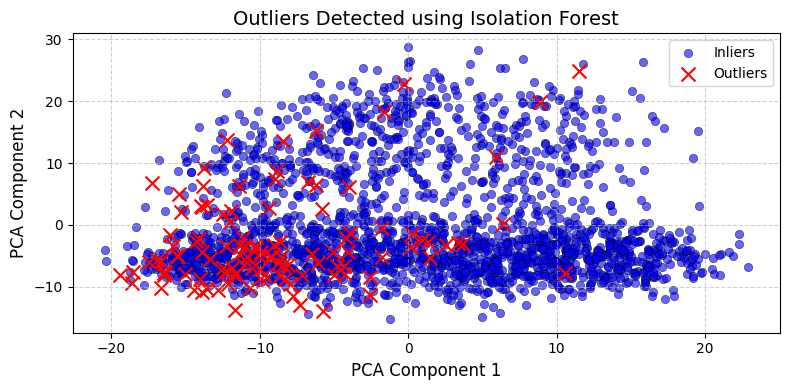

In [68]:
# Fit Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=42)  # Set a random state for reproducibility
clf.fit(feature_matrix)

# Predict outliers
train_data['outlier'] = clf.predict(feature_matrix)
val_data['outlier'] = clf.predict(feature_matrix_val)

# Separate outliers for visualization before filtering
outliers = train_data[train_data['outlier'] == -1]

# Remove outliers from both datasets
train_data = train_data[train_data['outlier'] != -1]
val_data = val_data[val_data['outlier'] != -1]

# Create the scatter plot
plt.figure(figsize=(8, 4))

# Scatter plot for inliers
plt.scatter(train_data['pca_1'], train_data['pca_2'], 
            c='blue', label='Inliers', alpha=0.6, edgecolor='k', linewidth=0.5)

# Scatter plot for outliers
plt.scatter(outliers['pca_1'], outliers['pca_2'], 
            c='red', marker='x', s=100, label='Outliers', 
            alpha=1, edgecolor='k', linewidth=1.5)

# Customize the plot
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.title('Outliers Detected using Isolation Forest', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


## Preprocess images and spliting data 

In [69]:
# Define the number of classes
num_artists = len(train_data['artist'].unique())
num_genres = len(train_data['genre'].unique())
num_styles = len(train_data['style'].unique())

# Preprocess images on-the-fly
def preprocess_image(image_path, artist_label, genre_label, style_label):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Resize and normalize
    image = tf.image.resize(image, (256, 256))  # Resize to (256, 256)
    image = image / 255.0  # Normalize to [0, 1]
    # Create a dictionary of targets
    targets = {
        'artist': artist_label,
        'genre': genre_label,
        'style': style_label
    }
    return image, targets

# Create dataset function
def create_dataset(image_paths, artist_labels, genre_labels, style_labels):
    # Create dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, artist_labels, genre_labels, style_labels)
    )
    # Preprocess images on-the-fly
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Prepare training and validation datasets
BATCH_SIZE = 16  # Reduced batch size
train_dataset = create_dataset(
    train_data['image_path'].tolist(),
    train_data['artist'].values,
    train_data['genre'].values,
    train_data['style'].values
)
val_dataset = create_dataset(
    val_data['image_path'].tolist(),
    val_data['artist'].values,
    val_data['genre'].values,
    val_data['style'].values
)

# Calculate the number of samples in the training dataset
dataset_size = len(train_data)

# Define the split ratio (e.g., 80% training, 20% testing)
split_ratio = 0.8
split_size = int(split_ratio * dataset_size)

# Split the dataset before shuffling and batching
train_split = train_dataset.take(split_size)
test_split = train_dataset.skip(split_size)

# Prepare the training split
train_split = train_split.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare the testing split
test_split = test_split.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify the sizes of the splits
print(f"Train split size: {len(list(train_split))}")
print(f"Test split size: {len(list(test_split))}")

# Prepare the validation dataset
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Train split size: 107
Test split size: 27


## Define the model 

In [71]:
# Define the model using ResNet50 as a backbone
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)

# Output layers
style_output = Dense(num_styles, activation='softmax', name='style')(x)
artist_output = Dense(num_artists, activation='softmax', name='artist')(x)
genre_output = Dense(num_genres, activation='softmax', name='genre')(x)

# Build the model
model = Model(inputs, [style_output, artist_output, genre_output])
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,learning_rate=1e-4)  
model.compile(optimizer=optimizer,
              loss={'style': 'sparse_categorical_crossentropy',
                    'artist': 'sparse_categorical_crossentropy',
                    'genre': 'sparse_categorical_crossentropy'},
              metrics={'style': 'accuracy',
                       'artist': 'accuracy',
                       'genre': 'accuracy'})


# Print model summary
model.summary()

# Add callbacks for training
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ input_layer_24[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │    131,136 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ style (Dense)       │ (None, 16)        │      1,040 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist (Dense)      │ (None, 23)        │      1,495 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre (Dense)       │ (None, 9)         │        585 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,721,968 (90.49 MB)

 Trainable params: 134,256 (524.44 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [72]:

# Train the model
history = model.fit(train_split,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=[checkpoint, early_stopping])


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - artist_accuracy: 0.1009 - artist_loss: nan - genre_accuracy: 0.1165 - genre_loss: nan - loss: nan - style_accuracy: 0.0319 - style_loss: nan - val_artist_accuracy: 0.1093 - val_artist_loss: nan - val_genre_accuracy: 0.1282 - val_genre_loss: nan - val_loss: nan - val_style_accuracy: 0.0479 - val_style_loss: nan
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - artist_accuracy: 0.1051 - artist_loss: nan - genre_accuracy: 0.0918 - genre_loss: nan - loss: nan - style_accuracy: 0.0354 - style_loss: nan - val_artist_accuracy: 0.1093 - val_artist_loss: nan - val_genre_accuracy: 0.1282 - val_genre_loss: nan - val_loss: nan - val_style_accuracy: 0.0479 - val_style_loss: nan
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - artist_accuracy: 0.1053 - artist_loss: nan - genre_accuracy: 0.0909 - genre_loss: nan - loss: nan - style_accuracy: 0.0455 - style_loss: nan - val_artist_accuracy: 0.1093 - val_artist_loss: nan - val_genre_acc

## Evaluate the model on the test split

In [73]:

# Evaluate the model on the test split
test_steps = len(list(test_split)) // BATCH_SIZE
if test_steps == 0:
    raise ValueError("Test split is empty or too small. Adjust the dataset splitting logic.")
test_results = model.evaluate(test_split, steps=test_steps)
print(f"Test Loss: {test_results[0]}")
print(f"Test Style Accuracy: {test_results[1]}")
print(f"Test Artist Accuracy: {test_results[2]}")
print(f"Test Genre Accuracy: {test_results[3]}")

2025-03-24 19:46:57.387255: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - artist_accuracy: 0.0625 - artist_loss: nan - genre_accuracy: 0.0000e+00 - genre_loss: nan - loss: nan - style_accuracy: 0.0000e+00 - style_loss: nan
Test Loss: nan
Test Style Accuracy: nan
Test Artist Accuracy: nan
Test Genre Accuracy: nan
